In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import time

import tensorflow as tf
from tensorflow.keras import layers
from tqdm import tqdm

2024-04-16 06:24:11.976828: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 06:24:11.976925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 06:24:12.093961: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(500, 362, 3) (256, 256, 3)
255 0 255 0


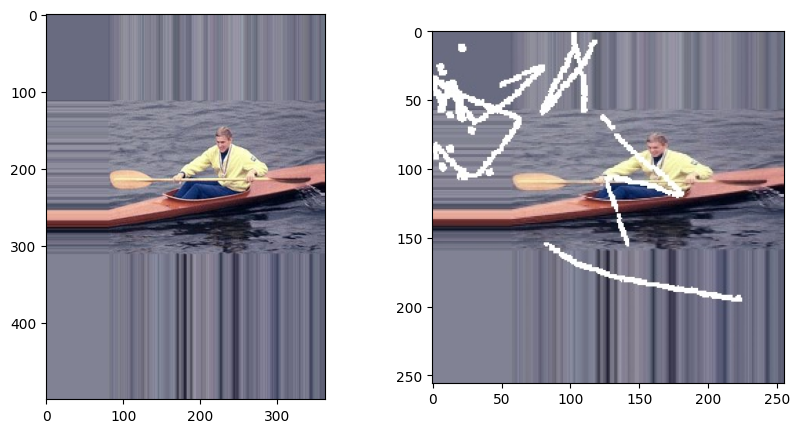

In [2]:
image_color = PIL.Image.open("/kaggle/input/humanface8000/landscape Images/color/10002.jpg")
image_gray = PIL.Image.open("/kaggle/input/humanface8000/landscape Images/gray/10002.jpg")

print(np.array(image_color).shape, np.array(image_gray).shape)
print(np.max(image_color), np.min(image_color), np.max(image_gray), np.min(image_gray))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image_color)

plt.subplot(1,2,2)
plt.imshow(image_gray)

In [3]:
color_dir = '/kaggle/input/humanface8000/landscape Images/color/'
gray_dir = '/kaggle/input/humanface8000/landscape Images/gray/'

img_height, img_width = 256, 256
batch_size = 64

color_train_dataset = tf.keras.utils.image_dataset_from_directory(
    color_dir, labels=None,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

color_test_dataset = tf.keras.utils.image_dataset_from_directory(
    color_dir, labels=None,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

gray_train_dataset = tf.keras.utils.image_dataset_from_directory(
    gray_dir, labels=None,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

gray_test_dataset = tf.keras.utils.image_dataset_from_directory(
    gray_dir, labels=None,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

normalization_layer = tf.keras.layers.Rescaling(1./255)
color_train_dataset = color_train_dataset.map(lambda x: normalization_layer(x))
color_test_dataset = color_test_dataset.map(lambda x: normalization_layer(x))
gray_train_dataset = gray_train_dataset.map(lambda x: normalization_layer(x))
gray_test_dataset = gray_test_dataset.map(lambda x: normalization_layer(x))

train_dataset = tf.data.Dataset.zip((color_train_dataset, gray_train_dataset))
test_dataset = tf.data.Dataset.zip((color_test_dataset, gray_test_dataset))

Found 8164 files.
Using 7348 files for training.
Found 8164 files.
Using 816 files for validation.
Found 8164 files.
Using 7348 files for training.
Found 8164 files.
Using 816 files for validation.


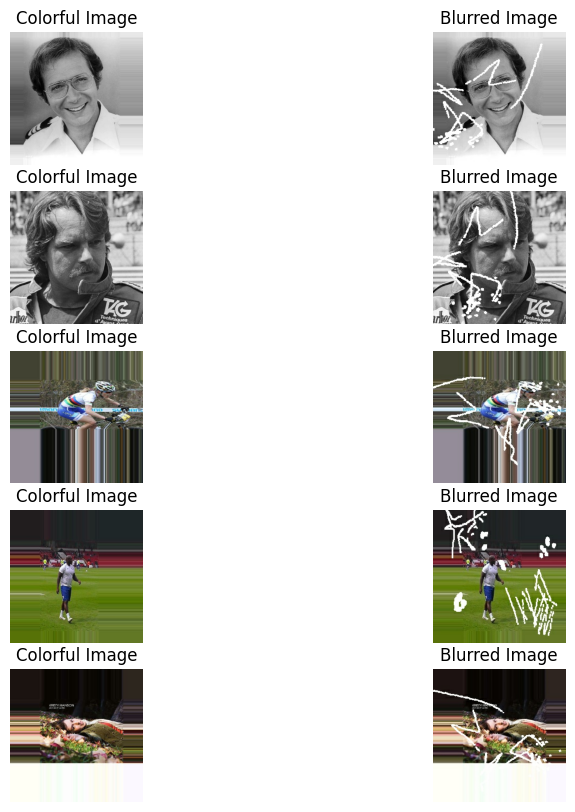

(64, 256, 256, 3) (64, 256, 256, 3)


In [4]:
for (color_images, blur_images) in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(5):
        plt.subplot(5, 2, 2*i + 1)
        plt.imshow(color_images[i])
        plt.axis('off')
        plt.title('Colorful Image')
        
        plt.subplot(5, 2, 2*i + 2)
        plt.imshow(blur_images[i]) 
        plt.axis('off')
        plt.title('Blurred Image')
    plt.show()
    print(color_images.shape, blur_images.shape)

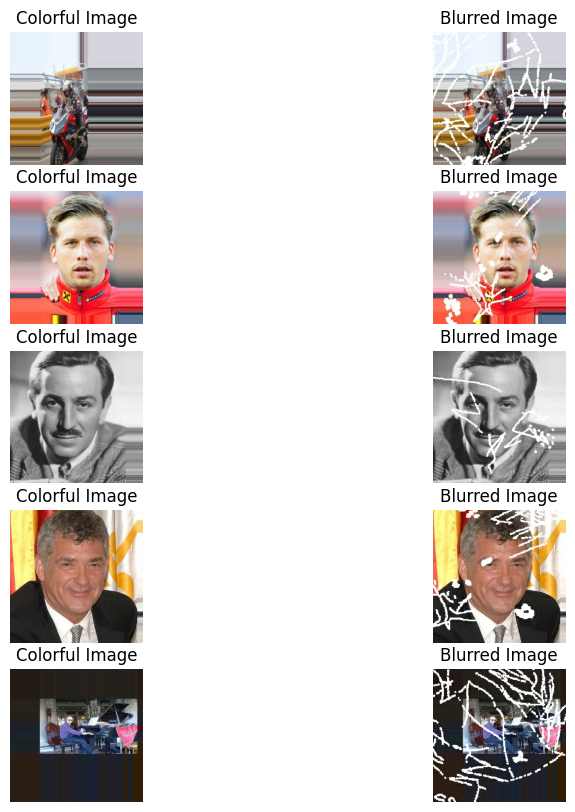

(64, 256, 256, 3) (64, 256, 256, 3)


In [5]:
for (color_images, blur_images) in test_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(5):
        plt.subplot(5, 2, 2*i + 1)
        plt.imshow(color_images[i])
        plt.axis('off')
        plt.title('Colorful Image')
        
        plt.subplot(5, 2, 2*i + 2)
        plt.imshow(blur_images[i]) 
        plt.axis('off')
        plt.title('Blurred Image')
    plt.show()
    print(color_images.shape, blur_images.shape)

In [6]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(64, 3, strides=2, input_shape=(256, 256, 3), padding='same',kernel_initializer='he_normal', use_bias=False)
        self.conv2 = layers.Conv2D(128, 3, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)
        self.conv3 = layers.Conv2D(128, 3, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)
        self.conv4 = layers.Conv2D(256, 3, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)
        self.conv5 = layers.Conv2D(256, 3, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)
        self.conv6 = layers.Conv2D(512, 3, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)
        self.conv7 = layers.Conv2D(512, 3, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)
        self.conv8 = layers.Conv2D(512, 3, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)
        
        self.norm1 = layers.BatchNormalization()
        self.norm2 = layers.BatchNormalization()
        self.norm3 = layers.BatchNormalization()
        self.norm4 = layers.BatchNormalization()
        self.norm5 = layers.BatchNormalization()
        self.norm6 = layers.BatchNormalization()
        self.norm7 = layers.BatchNormalization()
        self.norm8 = layers.BatchNormalization()
        
        self.act1 = layers.LeakyReLU()
        self.act2 = layers.LeakyReLU()
        self.act3 = layers.LeakyReLU()
        self.act4 = layers.LeakyReLU()
        self.act5 = layers.LeakyReLU()
        self.act6 = layers.LeakyReLU()
        self.act7 = layers.LeakyReLU()
        self.act8 = layers.LeakyReLU()
        
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(64)
        self.fc2 = tf.keras.layers.Dense(64)

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.norm1(x1)
        x1 = self.act1(x1)
        
        x2 = self.conv2(x1)
        x2 = self.norm2(x2)
        x2 = self.act2(x2)
        
        x3 = self.conv3(x2)
        x3 = self.norm3(x3)
        x3 = self.act3(x3)
        
        x4 = self.conv4(x3)
        x4 = self.norm4(x4)
        x4 = self.act4(x4)
        
        x5 = self.conv5(x4)
        x5 = self.norm5(x5)
        x5 = self.act5(x5)
        
        x6 = self.conv6(x5)
        x6 = self.norm6(x6)
        x6 = self.act6(x6)
        
        x7 = self.conv7(x6)
        x7 = self.norm7(x7)
        x7 = self.act7(x7)
        
        x8 = self.conv8(x7)
        x8 = self.norm8(x8)
        x8 = self.act8(x8)
        
        x9 = self.flatten(x8)
        mu = self.fc1(x9)
        logvar = self.fc2(x9)
        return mu, logvar, (x1, x2, x3, x4, x5, x6, x7)

class Decoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = tf.keras.layers.Dense(512, activation='relu', input_shape=(64,))
        self.fc2 = tf.keras.layers.Dense(512 * 1 * 1, activation='relu')
        self.reshape = tf.keras.layers.Reshape((1, 1, 512))
        self.conv1 = layers.Conv2DTranspose(512, 3, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False)
        self.conv2 = layers.Conv2DTranspose(512, 3, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False)
        self.conv3 = layers.Conv2DTranspose(256, 3, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False)
        self.conv4 = layers.Conv2DTranspose(256, 3, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False)
        self.conv5 = layers.Conv2DTranspose(128, 3, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False)
        self.conv6 = layers.Conv2DTranspose(128, 3, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False)
        self.conv7 = layers.Conv2DTranspose(64, 3, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False)
        
        self.norm1 = layers.BatchNormalization()
        self.norm2 = layers.BatchNormalization()
        self.norm3 = layers.BatchNormalization()
        self.norm4 = layers.BatchNormalization()
        self.norm5 = layers.BatchNormalization()
        self.norm6 = layers.BatchNormalization()
        self.norm7 = layers.BatchNormalization()
        
        self.act1 = layers.ReLU()
        self.act2 = layers.ReLU()
        self.act3 = layers.ReLU()
        self.act4 = layers.ReLU()
        self.act5 = layers.ReLU()
        self.act6 = layers.ReLU()
        self.act7 = layers.ReLU()
        
        self.conv = layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding='same', activation='relu')
        
    def call(self, z, encoder_outputs):
        z = self.fc1(z)
        z = self.fc2(z)
        z = self.reshape(z)
        
        z = self.conv1(z)
        z = self.norm1(z)
        z = tf.keras.layers.Add()([self.act1(z), encoder_outputs[6]])  # skip connection
        
        z = self.conv2(z)
        z = self.norm2(z)
        z = tf.keras.layers.Add()([self.act2(z), encoder_outputs[5]])  # skip connection
        
        z = self.conv3(z)
        z = self.norm3(z)
        z = tf.keras.layers.Add()([self.act3(z), encoder_outputs[4]])  # skip connection
        
        z = self.conv4(z)
        z = self.norm4(z)
        z = tf.keras.layers.Add()([self.act4(z), encoder_outputs[3]])  # skip connection
        
        z = self.conv5(z)
        z = self.norm5(z)
        z = tf.keras.layers.Add()([self.act5(z), encoder_outputs[2]])  # skip connection
        
        z = self.conv6(z)
        z = self.norm6(z)
        z = tf.keras.layers.Add()([self.act6(z), encoder_outputs[1]])  # skip connection
        
        z = self.conv7(z)
        z = self.norm7(z)
        z = tf.keras.layers.Add()([self.act7(z), encoder_outputs[0]])  # skip connection
        z = self.conv(z)
        return z
    
class CVAE(tf.keras.Model):

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder()
        self.decoder = Decoder()

    @tf.function
    def sample(self, eps=None, encoder_outputs=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, encoder_outputs, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar, encoder_outputs = self.encoder(x)
        return mean, logvar, encoder_outputs

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, encoder_outputs, apply_sigmoid=False):
        logits = self.decoder(z, encoder_outputs)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [7]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, y, x):
    mean, logvar, encoder_outputs = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z, encoder_outputs)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, y, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, y, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [8]:
epochs = 100
latent_dim = 64
num_examples_to_generate = 5

random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
def generate_and_save_images(model, epoch, test_sample, actual_outputs):
    mean, logvar, encoder_outputs = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(eps=z,  encoder_outputs=encoder_outputs)
    fig = plt.figure(figsize=(5, 5))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 3, 3*i + 1)
        plt.imshow(test_sample[i, :, :, :])
        plt.axis('off')
        
        plt.subplot(5, 3, 3*i + 2)
        plt.imshow(actual_outputs[i, :, :, :])
        plt.axis('off')
        
        plt.subplot(5, 3, 3*i + 3)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [10]:
for (color_images, gray_images) in test_dataset.take(1):
    test_sample = gray_images[0:num_examples_to_generate, :, :, :]
    actual_outputs = color_images[0:num_examples_to_generate, :, :, :]

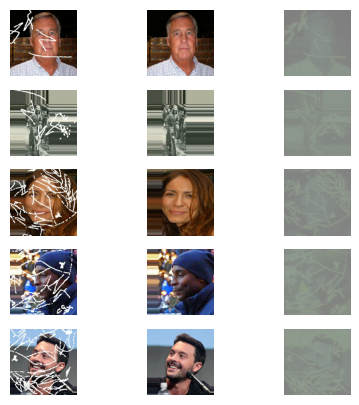

100%|██████████| 115/115 [00:41<00:00,  2.80it/s]


Epoch: 1, Test set ELBO: -130080.5390625, time elapse for current epoch: 41.12712264060974


100%|██████████| 115/115 [00:24<00:00,  4.78it/s]


Epoch: 2, Test set ELBO: -128359.4609375, time elapse for current epoch: 24.059157371520996


100%|██████████| 115/115 [00:24<00:00,  4.78it/s]


Epoch: 3, Test set ELBO: -127949.71875, time elapse for current epoch: 24.076029300689697


100%|██████████| 115/115 [00:24<00:00,  4.72it/s]


Epoch: 4, Test set ELBO: -127880.2890625, time elapse for current epoch: 24.39275884628296


100%|██████████| 115/115 [00:23<00:00,  4.79it/s]


Epoch: 5, Test set ELBO: -127685.859375, time elapse for current epoch: 23.996418714523315


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 6, Test set ELBO: -127630.109375, time elapse for current epoch: 24.122981786727905


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 7, Test set ELBO: -127524.5390625, time elapse for current epoch: 24.095948457717896


100%|██████████| 115/115 [00:24<00:00,  4.78it/s]


Epoch: 8, Test set ELBO: -127417.3671875, time elapse for current epoch: 24.06521439552307


100%|██████████| 115/115 [00:24<00:00,  4.79it/s]


Epoch: 9, Test set ELBO: -127322.8671875, time elapse for current epoch: 24.03663468360901


100%|██████████| 115/115 [00:24<00:00,  4.78it/s]


Epoch: 10, Test set ELBO: -127379.0078125, time elapse for current epoch: 24.080995082855225


100%|██████████| 115/115 [00:24<00:00,  4.79it/s]


Epoch: 11, Test set ELBO: -127044.015625, time elapse for current epoch: 24.04137873649597


100%|██████████| 115/115 [00:23<00:00,  4.80it/s]


Epoch: 12, Test set ELBO: -126755.5078125, time elapse for current epoch: 23.98365306854248


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 13, Test set ELBO: -126701.84375, time elapse for current epoch: 24.129794359207153


100%|██████████| 115/115 [00:24<00:00,  4.79it/s]


Epoch: 14, Test set ELBO: -126641.9609375, time elapse for current epoch: 24.00995445251465


100%|██████████| 115/115 [00:24<00:00,  4.76it/s]


Epoch: 15, Test set ELBO: -126638.6171875, time elapse for current epoch: 24.143133878707886


100%|██████████| 115/115 [00:24<00:00,  4.75it/s]


Epoch: 16, Test set ELBO: -126650.78125, time elapse for current epoch: 24.2220675945282


100%|██████████| 115/115 [00:24<00:00,  4.73it/s]


Epoch: 17, Test set ELBO: -126506.3671875, time elapse for current epoch: 24.318580627441406


100%|██████████| 115/115 [00:24<00:00,  4.74it/s]


Epoch: 18, Test set ELBO: -126509.546875, time elapse for current epoch: 24.26332402229309


100%|██████████| 115/115 [00:24<00:00,  4.78it/s]


Epoch: 19, Test set ELBO: -126480.7109375, time elapse for current epoch: 24.060296535491943


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 20, Test set ELBO: -126468.3828125, time elapse for current epoch: 24.13345456123352


100%|██████████| 115/115 [00:23<00:00,  4.79it/s]


Epoch: 21, Test set ELBO: -126410.8828125, time elapse for current epoch: 23.998968362808228


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 22, Test set ELBO: -126435.453125, time elapse for current epoch: 24.113595485687256


100%|██████████| 115/115 [00:24<00:00,  4.76it/s]


Epoch: 23, Test set ELBO: -126385.09375, time elapse for current epoch: 24.14303231239319


100%|██████████| 115/115 [00:24<00:00,  4.76it/s]


Epoch: 24, Test set ELBO: -126390.578125, time elapse for current epoch: 24.146296739578247


100%|██████████| 115/115 [00:24<00:00,  4.78it/s]


Epoch: 25, Test set ELBO: -126319.390625, time elapse for current epoch: 24.044487237930298


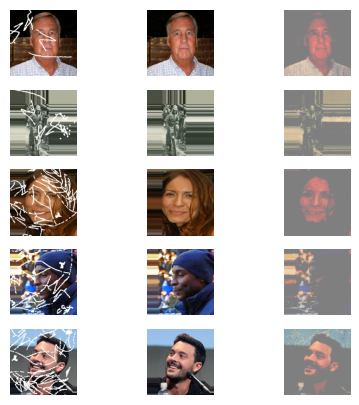

100%|██████████| 115/115 [00:24<00:00,  4.75it/s]


Epoch: 26, Test set ELBO: -126288.4296875, time elapse for current epoch: 24.2027428150177


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 27, Test set ELBO: -126260.90625, time elapse for current epoch: 24.110305070877075


100%|██████████| 115/115 [00:24<00:00,  4.76it/s]


Epoch: 28, Test set ELBO: -126282.6796875, time elapse for current epoch: 24.17718482017517


100%|██████████| 115/115 [00:24<00:00,  4.74it/s]


Epoch: 29, Test set ELBO: -126293.328125, time elapse for current epoch: 24.269657611846924


100%|██████████| 115/115 [00:24<00:00,  4.76it/s]


Epoch: 30, Test set ELBO: -126242.7578125, time elapse for current epoch: 24.182029724121094


100%|██████████| 115/115 [00:24<00:00,  4.76it/s]


Epoch: 31, Test set ELBO: -126200.421875, time elapse for current epoch: 24.17617630958557


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 32, Test set ELBO: -126198.84375, time elapse for current epoch: 24.11307191848755


100%|██████████| 115/115 [00:24<00:00,  4.74it/s]


Epoch: 33, Test set ELBO: -126218.515625, time elapse for current epoch: 24.292869091033936


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 34, Test set ELBO: -126226.390625, time elapse for current epoch: 24.098572254180908


100%|██████████| 115/115 [00:24<00:00,  4.76it/s]


Epoch: 35, Test set ELBO: -126188.5546875, time elapse for current epoch: 24.17343235015869


100%|██████████| 115/115 [00:24<00:00,  4.74it/s]


Epoch: 36, Test set ELBO: -126176.2109375, time elapse for current epoch: 24.28689193725586


100%|██████████| 115/115 [00:24<00:00,  4.75it/s]


Epoch: 37, Test set ELBO: -126189.9140625, time elapse for current epoch: 24.22779154777527


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 38, Test set ELBO: -126184.96875, time elapse for current epoch: 24.13584804534912


100%|██████████| 115/115 [00:24<00:00,  4.75it/s]


Epoch: 39, Test set ELBO: -126168.15625, time elapse for current epoch: 24.202933073043823


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 40, Test set ELBO: -126134.5, time elapse for current epoch: 24.139477968215942


100%|██████████| 115/115 [00:24<00:00,  4.78it/s]


Epoch: 41, Test set ELBO: -126084.4140625, time elapse for current epoch: 24.07941770553589


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 42, Test set ELBO: -126109.734375, time elapse for current epoch: 24.102750062942505


100%|██████████| 115/115 [00:23<00:00,  4.80it/s]


Epoch: 43, Test set ELBO: -126108.2578125, time elapse for current epoch: 23.986136436462402


100%|██████████| 115/115 [00:24<00:00,  4.72it/s]


Epoch: 44, Test set ELBO: -126091.21875, time elapse for current epoch: 24.348926067352295


100%|██████████| 115/115 [00:24<00:00,  4.79it/s]


Epoch: 45, Test set ELBO: -126104.40625, time elapse for current epoch: 24.027219533920288


100%|██████████| 115/115 [00:24<00:00,  4.79it/s]


Epoch: 46, Test set ELBO: -126127.6796875, time elapse for current epoch: 24.03765034675598


100%|██████████| 115/115 [00:24<00:00,  4.79it/s]


Epoch: 47, Test set ELBO: -126092.984375, time elapse for current epoch: 24.02748203277588


100%|██████████| 115/115 [00:24<00:00,  4.78it/s]


Epoch: 48, Test set ELBO: -126051.96875, time elapse for current epoch: 24.075889587402344


100%|██████████| 115/115 [00:24<00:00,  4.78it/s]


Epoch: 49, Test set ELBO: -126101.828125, time elapse for current epoch: 24.044482231140137


100%|██████████| 115/115 [00:24<00:00,  4.78it/s]


Epoch: 50, Test set ELBO: -126086.578125, time elapse for current epoch: 24.07191491127014


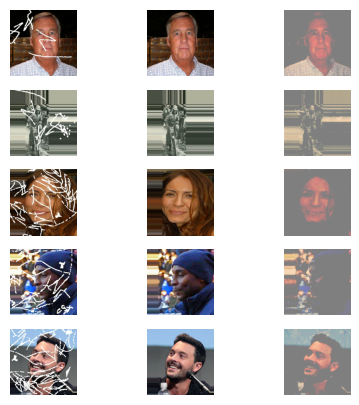

100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 51, Test set ELBO: -126104.234375, time elapse for current epoch: 24.13098931312561


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 52, Test set ELBO: -126039.0703125, time elapse for current epoch: 24.11752486228943


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 53, Test set ELBO: -126073.0390625, time elapse for current epoch: 24.129064321517944


100%|██████████| 115/115 [00:24<00:00,  4.74it/s]


Epoch: 54, Test set ELBO: -125995.5, time elapse for current epoch: 24.272643327713013


100%|██████████| 115/115 [00:24<00:00,  4.76it/s]


Epoch: 55, Test set ELBO: -126055.265625, time elapse for current epoch: 24.17505192756653


100%|██████████| 115/115 [00:24<00:00,  4.78it/s]


Epoch: 56, Test set ELBO: -126015.9609375, time elapse for current epoch: 24.08490800857544


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 57, Test set ELBO: -126016.8203125, time elapse for current epoch: 24.106385707855225


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 58, Test set ELBO: -126000.90625, time elapse for current epoch: 24.130540370941162


100%|██████████| 115/115 [00:24<00:00,  4.78it/s]


Epoch: 59, Test set ELBO: -126047.5, time elapse for current epoch: 24.048908233642578


100%|██████████| 115/115 [00:24<00:00,  4.76it/s]


Epoch: 60, Test set ELBO: -126029.59375, time elapse for current epoch: 24.154855012893677


100%|██████████| 115/115 [00:24<00:00,  4.75it/s]


Epoch: 61, Test set ELBO: -125972.09375, time elapse for current epoch: 24.217480659484863


100%|██████████| 115/115 [00:24<00:00,  4.76it/s]


Epoch: 62, Test set ELBO: -126003.4296875, time elapse for current epoch: 24.159873247146606


100%|██████████| 115/115 [00:23<00:00,  4.79it/s]


Epoch: 63, Test set ELBO: -126018.796875, time elapse for current epoch: 24.00387454032898


100%|██████████| 115/115 [00:24<00:00,  4.75it/s]


Epoch: 64, Test set ELBO: -125992.125, time elapse for current epoch: 24.213815212249756


100%|██████████| 115/115 [00:24<00:00,  4.78it/s]


Epoch: 65, Test set ELBO: -126016.09375, time elapse for current epoch: 24.058125734329224


100%|██████████| 115/115 [00:24<00:00,  4.78it/s]


Epoch: 66, Test set ELBO: -126022.2421875, time elapse for current epoch: 24.088629961013794


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 67, Test set ELBO: -126039.265625, time elapse for current epoch: 24.092607021331787


100%|██████████| 115/115 [00:24<00:00,  4.75it/s]


Epoch: 68, Test set ELBO: -125981.3828125, time elapse for current epoch: 24.206202745437622


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 69, Test set ELBO: -126006.75, time elapse for current epoch: 24.104223489761353


100%|██████████| 115/115 [00:24<00:00,  4.78it/s]


Epoch: 70, Test set ELBO: -125937.4453125, time elapse for current epoch: 24.054429054260254


100%|██████████| 115/115 [00:24<00:00,  4.78it/s]


Epoch: 71, Test set ELBO: -125971.4921875, time elapse for current epoch: 24.048648595809937


100%|██████████| 115/115 [00:24<00:00,  4.78it/s]


Epoch: 72, Test set ELBO: -126024.875, time elapse for current epoch: 24.057734727859497


100%|██████████| 115/115 [00:24<00:00,  4.76it/s]


Epoch: 73, Test set ELBO: -125935.46875, time elapse for current epoch: 24.153582334518433


100%|██████████| 115/115 [00:24<00:00,  4.79it/s]


Epoch: 74, Test set ELBO: -125934.984375, time elapse for current epoch: 24.011021614074707


100%|██████████| 115/115 [00:24<00:00,  4.74it/s]


Epoch: 75, Test set ELBO: -125957.046875, time elapse for current epoch: 24.262816190719604


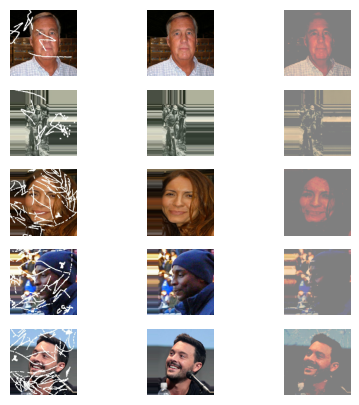

100%|██████████| 115/115 [00:24<00:00,  4.78it/s]


Epoch: 76, Test set ELBO: -125978.484375, time elapse for current epoch: 24.073659420013428


100%|██████████| 115/115 [00:24<00:00,  4.75it/s]


Epoch: 77, Test set ELBO: -126051.859375, time elapse for current epoch: 24.2014479637146


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 78, Test set ELBO: -125908.4921875, time elapse for current epoch: 24.133758068084717


100%|██████████| 115/115 [00:23<00:00,  4.79it/s]


Epoch: 79, Test set ELBO: -125896.2109375, time elapse for current epoch: 24.005206823349


100%|██████████| 115/115 [00:24<00:00,  4.76it/s]


Epoch: 80, Test set ELBO: -125948.4609375, time elapse for current epoch: 24.166884660720825


100%|██████████| 115/115 [00:23<00:00,  4.79it/s]


Epoch: 81, Test set ELBO: -125949.9921875, time elapse for current epoch: 23.996487855911255


100%|██████████| 115/115 [00:24<00:00,  4.71it/s]


Epoch: 82, Test set ELBO: -125920.421875, time elapse for current epoch: 24.418918132781982


100%|██████████| 115/115 [00:24<00:00,  4.75it/s]


Epoch: 83, Test set ELBO: -125968.671875, time elapse for current epoch: 24.218006134033203


100%|██████████| 115/115 [00:24<00:00,  4.72it/s]


Epoch: 84, Test set ELBO: -125949.40625, time elapse for current epoch: 24.398610591888428


100%|██████████| 115/115 [00:24<00:00,  4.76it/s]


Epoch: 85, Test set ELBO: -125977.84375, time elapse for current epoch: 24.16770601272583


100%|██████████| 115/115 [00:24<00:00,  4.74it/s]


Epoch: 86, Test set ELBO: -125931.0078125, time elapse for current epoch: 24.298997402191162


100%|██████████| 115/115 [00:24<00:00,  4.76it/s]


Epoch: 87, Test set ELBO: -125908.609375, time elapse for current epoch: 24.17566418647766


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 88, Test set ELBO: -125939.1640625, time elapse for current epoch: 24.103574991226196


100%|██████████| 115/115 [00:24<00:00,  4.71it/s]


Epoch: 89, Test set ELBO: -125933.21875, time elapse for current epoch: 24.435264587402344


100%|██████████| 115/115 [00:24<00:00,  4.79it/s]


Epoch: 90, Test set ELBO: -125893.9140625, time elapse for current epoch: 24.04064440727234


100%|██████████| 115/115 [00:24<00:00,  4.75it/s]


Epoch: 91, Test set ELBO: -125937.140625, time elapse for current epoch: 24.22008442878723


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 92, Test set ELBO: -125925.203125, time elapse for current epoch: 24.13480257987976


100%|██████████| 115/115 [00:24<00:00,  4.75it/s]


Epoch: 93, Test set ELBO: -125906.515625, time elapse for current epoch: 24.22059655189514


100%|██████████| 115/115 [00:24<00:00,  4.79it/s]


Epoch: 94, Test set ELBO: -125916.5703125, time elapse for current epoch: 24.035005569458008


100%|██████████| 115/115 [00:24<00:00,  4.79it/s]


Epoch: 95, Test set ELBO: -125897.5078125, time elapse for current epoch: 24.035579681396484


100%|██████████| 115/115 [00:24<00:00,  4.79it/s]


Epoch: 96, Test set ELBO: -125859.53125, time elapse for current epoch: 24.038411140441895


100%|██████████| 115/115 [00:24<00:00,  4.78it/s]


Epoch: 97, Test set ELBO: -125920.0390625, time elapse for current epoch: 24.066680192947388


100%|██████████| 115/115 [00:24<00:00,  4.78it/s]


Epoch: 98, Test set ELBO: -125934.28125, time elapse for current epoch: 24.07150888442993


100%|██████████| 115/115 [00:24<00:00,  4.79it/s]


Epoch: 99, Test set ELBO: -125888.5546875, time elapse for current epoch: 24.025760412216187


100%|██████████| 115/115 [00:24<00:00,  4.77it/s]


Epoch: 100, Test set ELBO: -125884.796875, time elapse for current epoch: 24.124812602996826


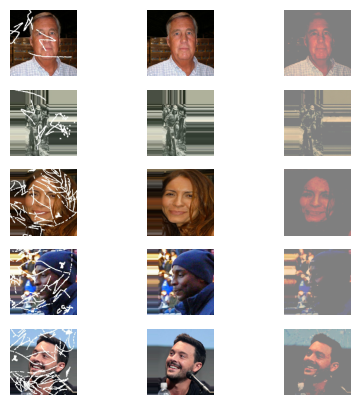

In [11]:
generate_and_save_images(model, 0, test_sample, actual_outputs)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for i, (train_y,train_x) in tqdm(train_dataset.enumerate()):
        train_step(model, train_y, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for (test_y,test_x) in test_dataset:
        loss(compute_loss(model, test_y, test_x))
    elbo = -loss.result()
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
    if epoch % 25 == 0:
        generate_and_save_images(model, epoch, test_sample, actual_outputs)

In [12]:
from PIL import Image

def transform_image(image):
    maximum = np.max(image)
    image = image/maximum*255
    image = np.array(image).astype('uint8')
    return image

In [13]:
from skimage.metrics import mean_squared_error, normalized_root_mse, structural_similarity
mse = 0
nrmse = 0
ssim = 0
total_images = 0
for n, (target, input_image) in tqdm(test_dataset.enumerate()):
    total_images += target.shape[0]
    for i in range(target.shape[0]):
        t_im = transform_image(target[i])
        p_im = transform_image(input_image[i])
        mse += mean_squared_error(t_im, p_im)
        nrmse += normalized_root_mse(t_im, p_im)
        ssim += structural_similarity(t_im, p_im, channel_axis=2)
mse /= total_images
nrmse /= total_images
ssim /= total_images

print(mse, nrmse, ssim)

100%|██████████| 13/13 [00:18<00:00,  1.39s/it]

2522.91658837811 0.40527478503373393 0.754038023587476


In [14]:
from skimage.metrics import mean_squared_error, normalized_root_mse, structural_similarity
mse = 0
nrmse = 0
ssim = 0
total_images = 0
for n, (target, input_image) in tqdm(test_dataset.enumerate()):
    mean, logvar, encoder_outputs = model.encode(input_image)
    z = model.reparameterize(mean, logvar)
    predicted_images = model.sample(eps=z,  encoder_outputs=encoder_outputs)
    total_images += target.shape[0]
    for i in range(target.shape[0]):
        t_im = transform_image(target[i])
        p_im = transform_image(predicted_images[i])
        mse += mean_squared_error(t_im, p_im)
        nrmse += normalized_root_mse(t_im, p_im)
        ssim += structural_similarity(t_im, p_im, channel_axis=2)
mse /= total_images
nrmse /= total_images
ssim /= total_images

print(mse, nrmse, ssim)

100%|██████████| 13/13 [00:19<00:00,  1.47s/it]

4241.17327164669 0.5360138515245638 0.3987979677267181
